In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [90]:
prod_entry = pd.read_csv('C:/Users/Daniil_pc/Downloads/Данные о вводе товаров в оборот с 2021-11-22 по 2022-11-21.csv')
#prod_entry = pd.read_csv('C:/Users/Daniil_pc/Downloads/Данные о вводе товаров в оборот с 2022-11-22 по 2023-02-21 проверка.csv')
point_reference = pd.read_csv('C:/Users/Daniil_pc/Downloads/Справочник торговых точек.csv')
#prod_with = pd.read_csv('C:/Users/Daniil_pc/Downloads/Данные о выводе товаров из оборота с 2022-11-22 по 2023-02-21 проверка.csv')
prod_with = pd.read_csv('C:/Users/Daniil_pc/Downloads/Данные о выводе товаров из оборота с 2021-11-22 по 2022-11-21.csv')

Выделение топ 1000 gtin по выводу из оборота

In [91]:
prod_entry_cnt = prod_entry.groupby('gtin', as_index=False).agg({'cnt' : 'sum'}).rename(columns={'cnt' : 'consumption'})
prod_with_cnt = prod_with.groupby('gtin', as_index=False).agg({'cnt' : 'sum'})

top_1000_gtin = prod_with_cnt.merge(prod_entry_cnt, on='gtin', how='inner').sort_values('consumption')[-1000:].gtin

In [92]:
top_1000_prod_with = prod_with[prod_with.gtin.isin(top_1000_gtin)]

inn_reg = dict(zip(point_reference.inn, point_reference.region_code))
top_1000_prod_with['reg_id'] = top_1000_prod_with['inn'].map(inn_reg).dropna().astype('int') #попробовать заменить на join

# Создание датафрейма вывода из производства по регионам

In [93]:
def demand_by_region(df, interval='month'): #Возможные значения interval: month, week
    if interval == 'month':
        df['dt_d'] = df.dt.apply(lambda x: f'{x.year}.{x.month}')
    elif interval == 'week':
        df['dt_d'] = df.dt.apply(lambda x: f'{x.year}.{x.week}')
    else:
        print('Введен неправильный интервал')
        return
    grouped = df.groupby(['gtin', 'type_operation', 'reg_id', 'dt_d'], as_index=False).agg({'cnt' : 'sum', 'dt': 'max'})
    return grouped[['gtin', 'type_operation', 'reg_id', 'cnt', 'dt']]

Переименовывание типа операций в 2 класса: продано и выведено из оборота

In [94]:
sold_names = ['Продажа конечному потребителю в точке продаж', 
 'Дистанционная продажа конечному потребителю', 
 'Конечная продажа организации', 
 'Продажи за пределы РФ', 
 'Продажа по государственному контракту']
write_off = ['Списание / Вывод из оборота без получателя', 'Прочий тип вывода из оборота']

closed_gtin = top_1000_prod_with.copy()
 
closed_gtin.type_operation = closed_gtin.type_operation.apply(lambda x: 'sold' if x in sold_names else 'write_off')
closed_gtin.dt = pd.to_datetime(top_1000_prod_with.dt)

группировка датафрейма по gtin, type_operation, reg_id, dt_d с подсчетом общей суммы за неделю

In [97]:
flight_data = demand_by_region(closed_gtin, interval='week')

Удаление gtin, у которых есть данные меньше чем за 13 недель (нужно для работы предсказаний)

In [98]:
flight_data = flight_data[flight_data['type_operation'] == 'sold']

q = flight_data.groupby(['gtin', 'reg_id'], as_index=False).agg({'dt' : 'count', 'cnt' : 'sum'})
q = q[q.dt > 12]

qww = flight_data[flight_data.gtin.isin(q.groupby('gtin').cnt.sum().sort_values()[-100:].index.to_list())]
qww

,gtin,type_operation,reg_id,cnt,dt
7006,0282BDC89C99B4A3828F6EBAA32E6708,sold,50.0,6655,2021-11-28
7007,0282BDC89C99B4A3828F6EBAA32E6708,sold,50.0,4125,2021-12-05
7008,0282BDC89C99B4A3828F6EBAA32E6708,sold,50.0,1033,2021-12-12
7009,0282BDC89C99B4A3828F6EBAA32E6708,sold,50.0,776,2021-12-19
7010,0282BDC89C99B4A3828F6EBAA32E6708,sold,50.0,261,2021-12-26
...,...,...,...,...,...
931242,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77.0,145,2022-01-02
931243,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77.0,5534,2022-02-13
931244,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77.0,5542,2022-02-20
931245,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77.0,3180,2022-02-27


In [ ]:
qww.to_csv('new_week_closed_gtin.csv', index=False)

# Создание датафрейма ввода в производство и вывода из производства по стране

In [54]:
def demand_country_without_date(df):
    grouped = df.groupby(['gtin', 'dt'], as_index=False).agg({'cnt' : 'sum'})
    return grouped[['gtin', 'cnt', 'dt']]

Группировка по gtin и dt с подсчетом общей суммы в день

In [ ]:
grouped_country_sold = demand_country_without_date(closed_gtin)

Подсчет кумулятивных сумм для введения в производство

In [55]:
grouped_country_just_sold = grouped_country_sold.sort_values('dt')
grouped_country_just_sold['cnt_cumsum'] = grouped_country_just_sold.groupby('gtin').cnt.cumsum()
grouped_country_just_sold

,gtin,cnt,dt,cnt_cumsum
34100,714C54AE621F433045BB1F502052ABFD,59,2022-11-22,59
48684,9E2A6A3E6B3B5916248B3980BA270BBC,251,2022-11-22,251
65630,CF98CDA56AA9505D05D3F51C404F85FD,22,2022-11-22,22
23879,522B96F9066E142A2DB98C97795E64A8,45,2022-11-22,45
65071,CDBEA39F10B7940DE5397B73F512EE6F,65,2022-11-22,65
...,...,...,...,...
20652,428580681C21CCC2DA098F10BC1D5B49,140,2023-02-21,8401
20560,41DBF239CB1DA8E392050F1F55ACB8CD,202,2023-02-21,29827
64277,CA9142169084414806A27E7204F3A2D2,223,2023-02-21,12996
19550,3F2FB695D4F981545902C4700A03BEF2,938,2023-02-21,102543


Подсчет кумулятивных сумм для выведения из производства с выделением топ 1000 gtin по выведению из производства

In [56]:
top_1000_prod_entry = prod_entry[prod_entry.gtin.isin(top_1000_gtin)]
top_1000_prod_entry.dt = pd.to_datetime(top_1000_prod_entry.dt)
mas1 = ['Импорт. Не ЕАЭС', 'РФ', 'Импорт. ЕАЭС', 'Принято от физического лица']
top_1000_prod_entry['type_operation'] = top_1000_prod_entry.operation_type.apply(lambda x: 'entering' if x in mas1 else 'else')
grouped_country_entry = demand_country_without_date(top_1000_prod_entry[top_1000_prod_entry.type_operation == 'entering']).sort_values('dt')
grouped_country_entry['cnt_cumsum'] = grouped_country_entry.groupby('gtin').cnt.cumsum()
grouped_country_entry

,gtin,cnt,dt,cnt_cumsum
3086,C7F18807913E04D804C573ED136F0D0D,5379,2022-11-22,5379
2959,C0D57D3B6C262FEFAA76EB74D6EDA3E9,5010,2022-11-22,5010
3844,FBDDC952026B20447B76EBD2EF8F4B5B,8565,2022-11-22,8565
2362,A0B7941CBA9B672A4D4770A03C8ADD3C,10032,2022-11-22,10032
2365,A113B66FD0F1B2B968C224126ECF0953,1500,2022-11-22,1500
...,...,...,...,...
176,0DC8786077E537CF63A0A3D6CABF8910,9306,2023-02-21,9306
715,34F1210B4E01269908C906323F54AAC4,9960,2023-02-21,41976
3901,FD875B7D4C490C080227D7ECB05023CF,45,2023-02-21,12600
2395,A3587AABEF2788A88A9AA73470FE1953,2336,2023-02-21,9344


Добавление первого по дате (со значением 0) и последнего по дате (с макс значением) значения cnt_cumsum для каждого gtin 

In [57]:
df_append_cnt_cumsum = grouped_country_entry.groupby('gtin', as_index=False).cnt_cumsum.max()
df_append_max = grouped_country_just_sold.groupby('gtin', as_index=False).dt.max()
df_append_max['cnt_cumsum'] = df_append_max.merge(df_append_cnt_cumsum, on=['gtin'], how='left').cnt_cumsum
df_append_min_1 = grouped_country_just_sold.groupby('gtin', as_index=False).dt.min()
df_append_min_2 = grouped_country_entry.groupby('gtin', as_index=False).dt.min()
df_append_min = df_append_min_2.merge(df_append_min_1[df_append_min_1.gtin.isin(df_append_min_2.gtin.values)], on='gtin', how='inner')
df_append_min['dt'] = df_append_min[['dt_x', 'dt_y']].min(axis=1)
df_append_min = df_append_min[['gtin', 'dt']] 
df_append_min['cnt_cumsum'] = 0
df_append = pd.concat([df_append_max, df_append_min])
df_append['cnt'] = 0
grouped_country_entry_fin = pd.concat([grouped_country_entry,df_append]).groupby(['gtin', 'dt'], as_index=False).cnt_cumsum.max().sort_values('dt')
grouped_country_just_sold_fin = pd.concat([grouped_country_just_sold[['gtin', 'dt', 'cnt_cumsum']], df_append_min]).groupby(['gtin', 'dt'], as_index=False).cnt_cumsum.max().sort_values('dt')

Добавление всех недостающих дней года в датафреймы

In [60]:
year_by_day = pd.DataFrame(pd.date_range(grouped_country_just_sold_fin.dt.min(), grouped_country_just_sold_fin.dt.max()))

In [61]:
gtins = grouped_country_just_sold_fin[['gtin']].drop_duplicates()

In [62]:
df_for_append = gtins.merge(year_by_day, how='cross').rename(columns={0: 'dt'})

In [64]:
super_puper_df_sold = grouped_country_just_sold_fin.merge(df_for_append, how='right', on=['gtin', 'dt']).sort_values('dt')
super_puper_df_sold_2 = super_puper_df_sold.groupby('gtin', as_index=False).cnt_cumsum.fillna(method='backfill')
super_puper_df_sold_3 = super_puper_df_sold_2.merge(super_puper_df_sold, how='inner', right_index=True, left_index=True)
super_puper_df_sold_3 = super_puper_df_sold_3.groupby('gtin', as_index=False).cnt_cumsum_x.fillna(method='ffill')
super_puper_df_sold_3 = super_puper_df_sold_3.merge(super_puper_df_sold, how='inner', right_index=True, left_index=True)

In [66]:
super_puper_df_entry = grouped_country_entry_fin.merge(df_for_append, how='right', on=['gtin', 'dt']).sort_values('dt')
super_puper_df_entry_2 = super_puper_df_entry.groupby('gtin', as_index=False).cnt_cumsum.fillna(method='backfill')
super_puper_df_entry_3 = super_puper_df_entry_2.merge(super_puper_df_entry, how='inner', right_index=True, left_index=True)
super_puper_df_entry_3 = super_puper_df_entry_3.groupby('gtin', as_index=False).cnt_cumsum_x.fillna(method='ffill')
super_puper_df_entry_3 = super_puper_df_entry_3.merge(super_puper_df_entry, how='inner', right_index=True, left_index=True)

In [67]:
super_puper_df_entry_4 = super_puper_df_entry_3.copy()
super_puper_df_entry_3 = super_puper_df_entry_4.dropna(subset='cnt_cumsum_x').drop(columns=['cnt_cumsum']).rename(columns={'cnt_cumsum_x' : 'cnt_cumsum'})
uniq_gtin = super_puper_df_entry_3.gtin.unique()
super_puper_df_sold_3 = super_puper_df_sold_3[super_puper_df_sold_3.gtin.isin(uniq_gtin)].drop(columns=['cnt_cumsum']).rename(columns={'cnt_cumsum_x' : 'cnt_cumsum'})

Соединение ввода в производство и вывода из производства в один датафрейм

In [70]:
super_puper_final_df = super_puper_df_entry_3.merge(super_puper_df_sold_3, how='inner', on=['gtin', 'dt']).rename(columns={'cnt_cumsum_x' : 'cnt_cumsum_entry', 'cnt_cumsum_y' : 'cnt_cumsum_sold'})

In [74]:
super_puper_final_df.to_csv('super_puper_final_df.csv')

<AxesSubplot:xlabel='dt', ylabel='cnt_cumsum'>

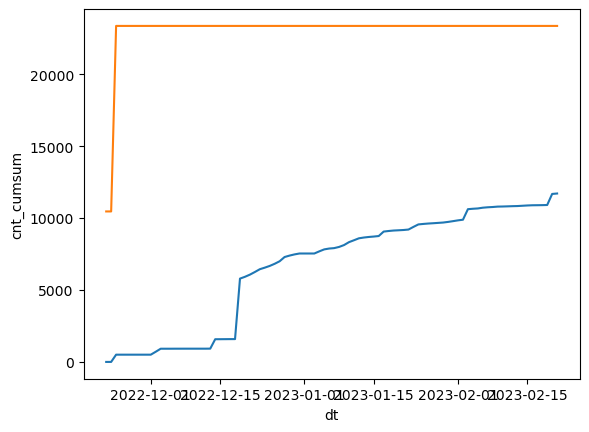

In [71]:
sns.lineplot(data=super_puper_df_sold_3[super_puper_df_sold_3.gtin == 'DCA08213622BA33C8D19CD551425EF15'], x='dt', y='cnt_cumsum')
sns.lineplot(data=super_puper_df_entry_3[super_puper_df_entry_3.gtin == 'DCA08213622BA33C8D19CD551425EF15'], x='dt', y='cnt_cumsum')

Создание датафрейма для сравнения предсказания с реальными данными, для этого изначально надо прочитать файлы по последним временным промежуткам

In [ ]:
predicted = pd.read_csv('C:/Users/Daniil_pc/Downloads/big_df_rus.csv')

In [88]:
super_puper_final_df_with_test = super_puper_final_df[super_puper_final_df.gtin.isin(predicted.gtin)]
super_puper_final_df_with_test['type'] = 'test'
super_puper_final_df_with_test['metric'] = 0
super_puper_final_df_with_test = pd.concat([super_puper_final_df_with_test, predicted]).sort_values(['gtin', 'dt'])
super_puper_final_df_with_test

,cnt_cumsum_entry,gtin,dt,cnt_cumsum_sold,type,metric
20448,0.0,0282BDC89C99B4A3828F6EBAA32E6708,2021-11-22,779.0,real_data,-0.025373
20449,18000.0,0282BDC89C99B4A3828F6EBAA32E6708,2021-11-23,1148.0,real_data,-0.025373
20450,18000.0,0282BDC89C99B4A3828F6EBAA32E6708,2021-11-24,4165.0,real_data,-0.025373
20451,18000.0,0282BDC89C99B4A3828F6EBAA32E6708,2021-11-25,4964.0,real_data,-0.025373
20452,18000.0,0282BDC89C99B4A3828F6EBAA32E6708,2021-11-26,5914.0,real_data,-0.025373
...,...,...,...,...,...,...
87764,20300.0,FC2186495AC107CB2BBBFF96D2DE6D71,2023-02-17,14793.0,test,0.000000
87987,20300.0,FC2186495AC107CB2BBBFF96D2DE6D71,2023-02-18,14799.0,test,0.000000
88832,20300.0,FC2186495AC107CB2BBBFF96D2DE6D71,2023-02-19,14800.0,test,0.000000
89825,20300.0,FC2186495AC107CB2BBBFF96D2DE6D71,2023-02-20,15307.0,test,0.000000


In [89]:
super_puper_final_df_with_test.to_csv('super_puper_final_df_with_test.csv')